Strategy rules:

1. Check if today's close is in the bottom n & of the day's range
2. If condition is met then enter on the close and exit the next day's close, unless the signal is repeated

In [2]:
# import libraries
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [3]:
# define starting variables
SYMBOL = "^GSPC"
STARTING_BALANCE = 10000
PCT_THRESH = 20

In [4]:
# define date range
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2024, 1, 1)
YEARS = (END - START).days/ 365.25

In [5]:
# download data
price = yf.download(SYMBOL, start=START, end=END)

price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [6]:
# drop redundant columns
price = price.drop(['Volume', 'Adj Close'], axis=1)

price.tail()

,Open,High,Low,Close
Date,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078


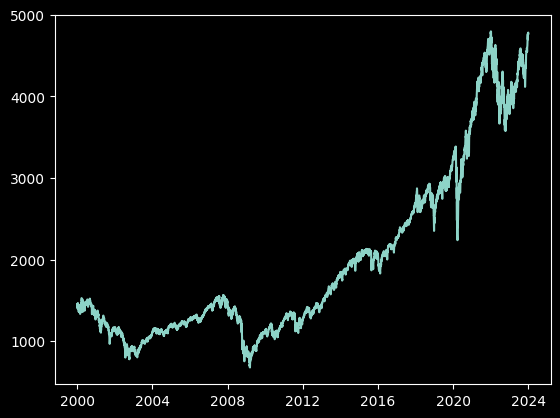

In [7]:
# plot chart
plt.style.use('dark_background')
plt.plot(price.Close)
plt.show()

In [8]:
# calculate benchmark return and balance
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price.tail()

,Open,High,Low,Close,Return,Bench_Bal
Date,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,32672.929032
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,32811.190721
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,32858.125743
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,32870.288987
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,32777.381936


In [9]:
# calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd

-56.78

In [10]:
# calculate additional columns for strategy

# daily range
price['Range'] = price.High - price.Low
# distance between close and daily low
price['Dist'] = abs(price.Close - price.Low)
# distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct
Date,,,,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,32672.929032,32961.065373,-288.136341,36.169922,17.859863,49.377666
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,32811.190721,32961.065373,-149.874651,26.270020,16.299805,62.047174
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,32858.125743,32961.065373,-102.939630,16.490234,12.680176,76.895061
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,32870.288987,32961.065373,-90.776386,12.319824,2.370117,19.238239
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,32777.381936,32961.065373,-183.683436,36.439941,17.839844,48.956840


In [11]:
# identify entries and allocate trading fees
price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))

In [12]:
# calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,,,
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,1.001660,32672.929032,32961.065373,-288.136341,36.169922,17.859863,49.377666,False,1.000000,60316.607377
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,1.004232,32811.190721,32961.065373,-149.874651,26.270020,16.299805,62.047174,False,1.000000,60316.607377
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,1.001430,32858.125743,32961.065373,-102.939630,16.490234,12.680176,76.895061,False,1.000000,60316.607377
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,1.000370,32870.288987,32961.065373,-90.776386,12.319824,2.370117,19.238239,True,1.000000,60316.607377
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,0.997174,32777.381936,32961.065373,-183.683436,36.439941,17.839844,48.956840,False,0.997174,60146.123993


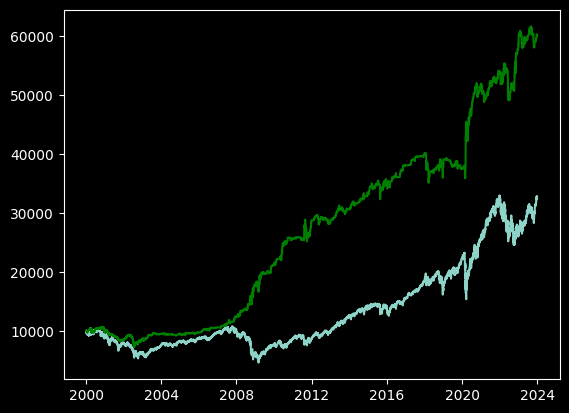

In [14]:
# plot balance
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal, color="g")

plt.show()

In [15]:
# calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-32.29

In [16]:
#calculate metrics
bench_return = round(((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

Benchmark Total return: 227.77%
Benchmark CAGR: 5.07
Benchmark DD: -56.78%

System Total return: 501.46%
System CAGR: 7.76
System DD: -32.29%
Time in Market: 19%
Trades Won: 677
Trades Loss: 489
Winrate: 58.06%


In [17]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^N225']

In [18]:
#create backtesting function
def backtest(s):
    #download data
    price = yf.download(s, start=START, end=END)
    
    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], axis=1)
    
    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
    
    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100
    
    #identify entries and allocate trading fees
    price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))
    
    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())
    
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
    
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr

In [19]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


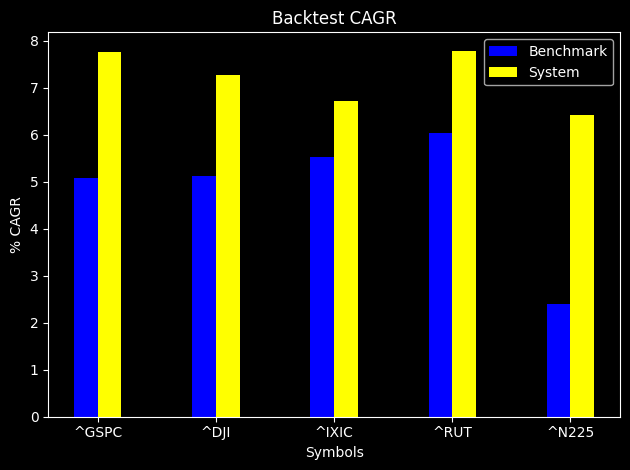

In [20]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark', color="blue")
plt.bar(x_indices + width / 2, sc, width = width, label = 'System', color="yellow")
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.show()